# Рекомендация тарифов

Оператор мобильной связи выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям один из новых тариф.

## Открываем и изучаем данные

In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
import seaborn as sns
from joblib import dump, load

In [3]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df['calls'] = df['calls'].astype('int')
df['messages'] = df['messages'].astype('int')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40,311.90,83,19915.42,0
1,85,516.75,56,22696.96,0
2,77,467.66,86,21060.45,0
3,106,745.53,81,8437.39,1
4,66,418.74,1,14502.75,0


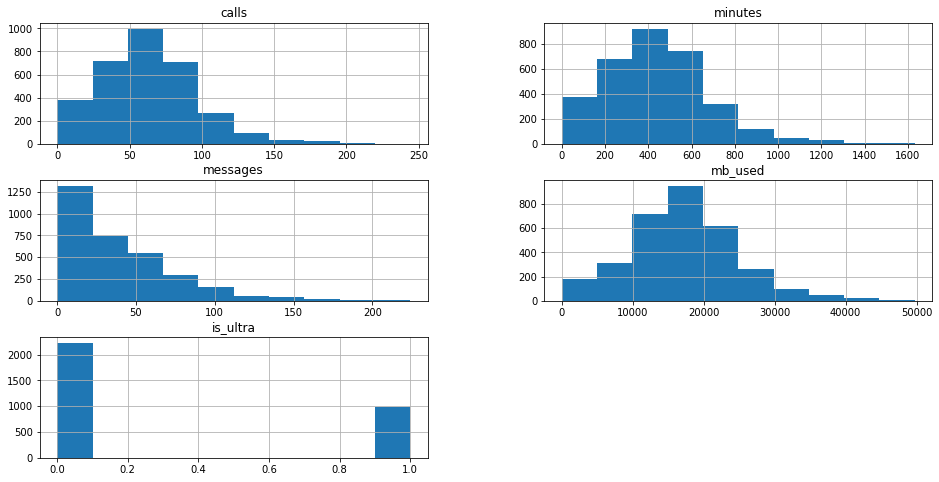

In [5]:
df.hist(figsize=(16, 8));

In [6]:
df.duplicated().sum()

0

***Данные хорошего качества, пропуски и дубликаты отсутствуют, значения распределены нормально, можно приступать к обучению модели.***

Проверим данные на сбалансированность

In [7]:
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

## Разбиваем данные на выборки

Целевой признак содержится в колонке 'is_ultra': 1 - если пользователь использует тариф Ультра и 0 - если использует тариф Смарт.  
Разобьем выборку на три набора данных: обучающий, валидационный и тестовый в пропорции 3:1:1 в одинаковой пропорции по тарифам по выборкам.

In [8]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

In [9]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target)
features_train, features_test, target_train, target_test = train_test_split(
    features_train, target_train, test_size=0.25, random_state=12345, stratify=target_train)

Проверим размеры выборок и пропорциональность классов в таргете

In [10]:
display(features_train.shape, features_test.shape, features_valid.shape, target_train.shape, target_test.shape, 
        target_valid.shape)

(1928, 4)

(643, 4)

(643, 4)

(1928,)

(643,)

(643,)

(0    1337
 1     591
 Name: is_ultra, dtype: int64,
 0    446
 1    197
 Name: is_ultra, dtype: int64,
 0    446
 1    197
 Name: is_ultra, dtype: int64)

## Исследуем модели

Для принятия решения о выборе модели - обучим Дерево решений, Случайный лес и Логистическую регрессию с разными значениями гиперпараметров и сравним точность предсказаний между собой

### Дерево решений

Точность лучшей модели дерева решений: 0.7993779160186625
Лучшая модель: DecisionTreeClassifier(max_depth=3, random_state=12345)


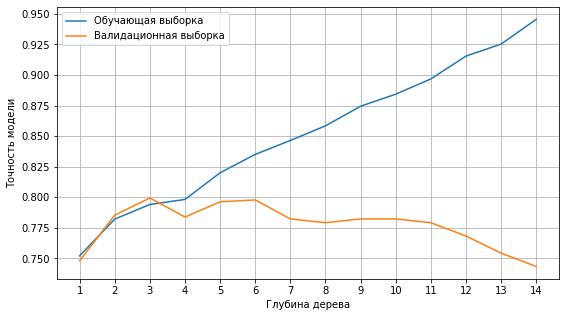

In [14]:
best_model = None
best_result = 0
result_valid_list = []
result_train_list = []
depth_list = []
for depth in range(1, 15):
    model = DecisionTreeClassifier(random_state=12345, max_depth = depth)#, class_weight='balanced')
    model.fit(features_train, target_train)
    result_train = model.score(features_train, target_train)
    result_train_list.append(result_train)
    predictions = model.predict(features_valid)
    result = accuracy_score(target_valid, predictions)
    #print(result)
    result_valid_list.append(result)
    depth_list.append(depth)
    if result > best_result:
        best_result = result
        best_model = model
print('Точность лучшей модели дерева решений:', best_result)
dump(best_model, 'best_model_tree.joblib');
print('Лучшая модель:', best_model)
plt.subplots(figsize=(9,5));
plt.plot(depth_list, result_train_list, label = 'Обучающая выборка');
plt.plot(depth_list, result_valid_list, label = 'Валидационная выборка');
plt.legend();
plt.ylabel('Точность модели');
plt.xlabel('Глубина дерева');
plt.xticks(depth_list);
plt.grid()

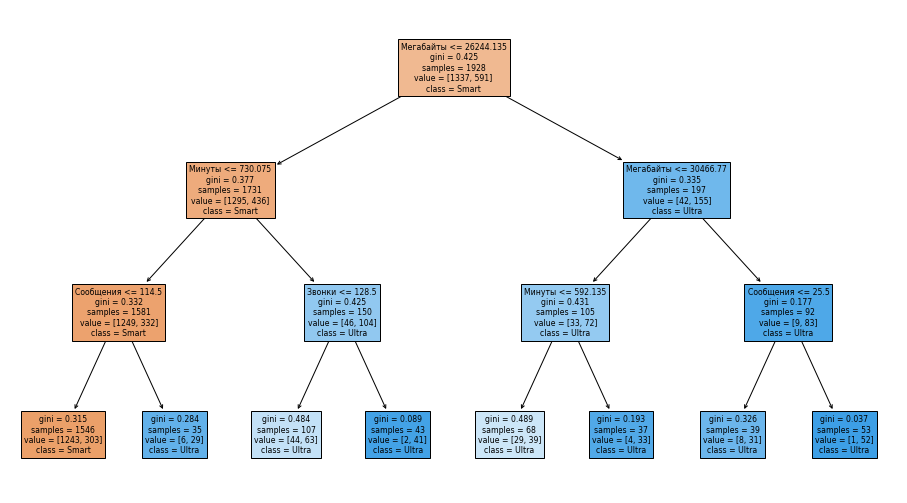

In [13]:
plt.subplots(figsize=(16,9))
tree.plot_tree(best_model, feature_names = ['Звонки', 'Минуты', 'Сообщения', 'Мегабайты'], class_names = ['Smart', 'Ultra'], filled=True);

### Случайный лес

In [13]:
%%time
best_model = None
best_result = 0
#result_valid_list = []
#result_train_list = []
#est_list = []
#depth_list = []
for est in range(10, 40):
    for depth in range(1,10):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345) #, class_weight='balanced')
        model.fit(features_train, target_train)
        #result_train = model.score(features_train, target_train)
        #result_train_list.append(result_train)
        predictions = model.predict(features_valid)
        result = accuracy_score(target_valid, predictions)
        #result_valid_list.append(result)
        #depth_list.append(depth)
        #est_list.append(est)
        #print(result)
        if result > best_result:
            best_result = result
            best_model = model
print('Точность лучшей модели случайного леса:', best_result)
dump(best_model, 'best_model_forest.joblib');
print("Лучшая модель:", best_model)
#plt.subplots(figsize=(9,5));
#plt.plot(depth_list, result_train_list, label = 'Обучающая выборка');
#plt.plot(depth_list, result_valid_list, label = 'Валидационная выборка');
#plt.legend();
#plt.ylabel('Точность модели');
#plt.xlabel('Глубина дерева');
#plt.xticks(depth_list);
#plt.grid()

Точность лучшей модели случайного леса: 0.8195956454121306
Лучшая модель: RandomForestClassifier(max_depth=6, n_estimators=30, random_state=12345)
CPU times: user 15.8 s, sys: 118 ms, total: 15.9 s
Wall time: 16 s


### Логистическая регрессия

In [14]:
model = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)
result = accuracy_score(target_valid, predictions)
print('Точность модели логистической регрессии:', result)
dump(model, 'best_model_regression.joblib');

Точность модели логистической регрессии: 0.7371695178849145


***Самая точная модель - Случайный лес***

## Проверяем модель на тестовой выборке

In [18]:
model = load('best_model_forest.joblib')
predictions = model.predict(features_test)
result = accuracy_score(target_test, predictions)
print(result)
model

0.8227060653188181


RandomForestClassifier(max_depth=6, n_estimators=30, random_state=12345)

Объединим обучающие и валидационную выборки и попробуем обучить модель на новом датасете, затем проверим на тестовой выборке

In [16]:
features_new = pd.concat([features_train, features_valid]).reset_index(drop=True)
target_new = pd.concat([target_train, target_valid]).reset_index(drop=True)
model = RandomForestClassifier(max_depth=6, n_estimators=30, random_state=12345)
model.fit(features_new, target_new)
predictions = model.predict(features_test)
result = accuracy_score(target_test, predictions)
print(result)

0.8180404354587869


***Точность предсказаний лучшей из обученных нами моделей (Случайный лес с 30 деревьями и глубиной 6) даёт удовлетворительный результат 82.3%***